* passage à uv, veuillez bien installer uv et initialiser un environnement virtuel et le connecter à jupyter (ou autre)

In [ ]:
!uv pip install -q bertopic spacy polars datasets

In [ ]:
!uv pip install -q https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.7.0/fr_core_news_sm-3.7.0-py3-none-any.whl

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from hdbscan import HDBSCAN
from scipy.cluster import hierarchy as sch
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from umap import UMAP
import polars as pl
import spacy

In [ ]:
nlp = spacy.load("fr_core_news_sm")  

In [ ]:
def preprocess(docs):
    cleaned = []
    for doc in nlp.pipe(docs, batch_size=20):
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        cleaned.append(' '.join(tokens))
    return cleaned

In [ ]:
NOM_PARQUET="echantillon_1000_hs_accords.parquet"

In [ ]:
df=pl.read_parquet(NOM_PARQUET)
docs=list(df["accorddocx"])

## BERTopic dans les grandes lignes

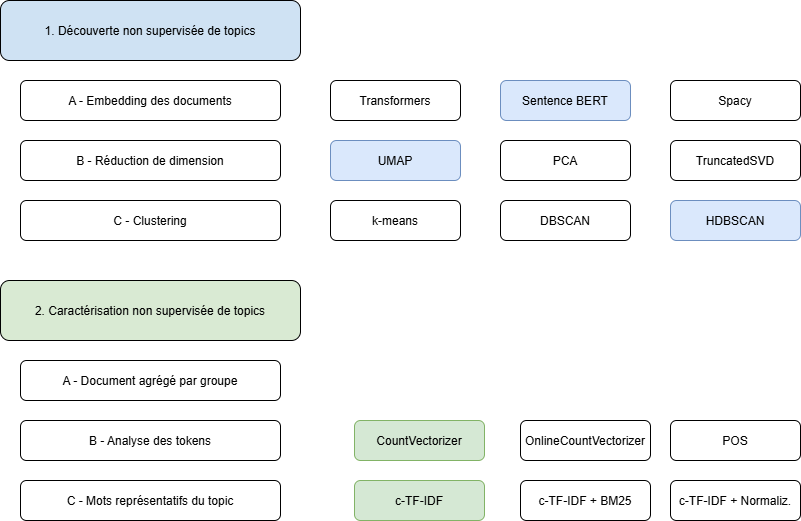

BERTopic = une méthodologie en deux parties :
1. Découverte non supervisée de topics
2. Caractérisation non supervisée de topics

1. Découverte non supervisée de topics
* A - il s'agit de plonger les documents dans un embedding (typiquement des embedding neuronaux)
* B - de reduire la dimension de l'embedding par des méthodes de projection/réduction de dimension (type ACP)
* C - faire du clustering (choix manuel ou auto du nombre de groupes)

A ce niveau là, chaque document possède son vecteur dans le prolongement réduit et est affecté à un groupe.

2. Caractérisation non supervisée de topics
* A - Pour chacun des groupes, construire un document agrégé
* B - Pour chaque document agrégé,  calculer les comptages de mots/tokens (Compte simple, compte pondérée TF-IDF etc; choix de la tokenisation, stopwords, etc.)
* C - En déduire les mots/tokens représentatives de la classe

## [Initiation] BERTopic (base) - sans preprocessing

In [ ]:
PREPROCESS=False

In [ ]:
if PREPROCESS:
    docs_cleaned = preprocess(docs)
else:
    docs_cleaned = docs

In [ ]:
topic_model = BERTopic(language="french")
topics, probs = topic_model.fit_transform(docs_cleaned)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(0)

In [ ]:
topic_model.get_document_info(docs_cleaned)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

**pas terrible, on a des stopwords : BERTopic n'enlève pas les stopwords en FR, on va le faire en preprocessing en dehors de la librairie (on peut le faire pendant, on verra après)**

## [Initiation] BERTopic (base) - avec preprocessing

*le preprocessing va mettre un peu de temps et les modèles vont davantage travailler*

In [ ]:
PREPROCESS=True

In [ ]:
if PREPROCESS:
    docs_cleaned = preprocess(docs)
else:
    docs_cleaned = docs

In [ ]:
topic_model = BERTopic(language="french")
topics, probs = topic_model.fit_transform(docs_cleaned)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(0)

In [ ]:
topic_model.get_document_info(docs_cleaned)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

## [Approndissement] BERTopic (KeyBERTInspired)

https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired

In [ ]:
representation_model = KeyBERTInspired()

topic_model = BERTopic(representation_model=representation_model,language="french")
topics, probs = topic_model.fit_transform(docs_cleaned)

In [ ]:
topic_model.get_topic_info()

## [Approndissement] BERTopic (MMR)

https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance

In [ ]:
representation_model = MaximalMarginalRelevance(diversity=0.3)

topic_model = BERTopic(representation_model=representation_model,language="french")
topics, probs = topic_model.fit_transform(docs_cleaned)

In [ ]:
topic_model.get_topic_info()

## [Approndissement] Hierarchical topics (depuis le modèle précédent)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(docs_cleaned)
hierarchical_topics

In [ ]:
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(docs_cleaned, linkage_function=linkage_function)

In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

## [Expertise] Composition des modules

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs_cleaned, show_progress_bar=True)

In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
vectorizer_model = CountVectorizer(stop_words=list(fr_stop), ngram_range=(1, 2))

In [ ]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("fr_core_news_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)
# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [ ]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs_cleaned, embeddings)

# Show topics
topic_model.get_topic_info()

## [Expertise] Autres

* Possibilité d'entraîner un modèle supervisé et de découvrir les relations entre topic : https://maartengr.github.io/BERTopic/getting_started/supervised/supervised.html
* Possibilité de donner des pistes à la découverte des topics avec des seed words : https://maartengr.github.io/BERTopic/getting_started/seed_words/seed_words.html

## Travaux pratiques

* refaire la même chose en découpant les documents en paragraphes (tous les paragraphes) (dans la première partie, 1 document = 1 vecteur, ici 1 documents = n vecteurs)

* refaire la même chose sur uniquement les paragraphes d'intérêt

* Est-ce pertinent de découper un document en phrases ?